#**CHAPTER 9 비지도학습**

* 비지도 학습은 입력 데이터가 주어지되 레이블은 주어지지 않는 학습 방식이다.

* 즉, 여러 문제를 학습함으로써 해당 데이터의 패턴, 특성 및 구조를 스스로 파악하여, 이를 통해 새로운 데이터에서 일정한 규칙성을 찾는 방법

* 비지도 학습 문제에는 클러스터링, 차원 압축, 이상 감지 등이 있다. 9장에서는 클러스터링에 대하여 공부함

##**9.1 2차원 입력 데이터**

* 클래스 분류 문제에서 다룬 2차원 입력 데이터 X를 사용하지만, 비지도 학습 문제는 세트로 되어 있는 클래스 데이터 T를 사용하지 않음

* 즉, 클래스 정보 없이, 입력 데이터가 비슷한 것끼리 클래스로 나누는 것이 클러스터링이다.


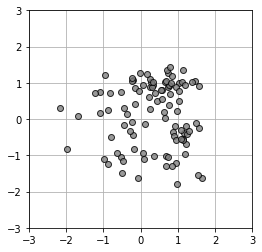

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# 데이터 생성 --------------------------------
np.random.seed(1)
N = 100
K = 3
T3 = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
X_col = ['cornflowerblue', 'black', 'white']
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 누적 확률
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T3[n, :] == 1, k]
                   + Mu[T3[n, :] == 1, k])


# 데이터를 그리기 ------------------------------
def show_data(x):
    plt.plot(x[:, 0], x[:, 1], linestyle='none',
             marker='o', markersize=6,
             markeredgecolor='black', color='gray', alpha=0.8)
    plt.grid(True)


# 메인 ------------------------------------
plt.figure(1, figsize=(4, 4))
show_data(X)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()
np.savez('data_ch9.npz', X=X, X_range0=X_range0,
         X_range1=X_range1)


* 2차원 입력 데이터 X의 분포를 T에 의한 색깔 구분 없이 나타냄

* 하지만 색깔 구분이 없어도 어느정도 분포의 경향을 알 수 있음

* 분포를 위쪽과 오른쪽 아래, 왼쪽 아래(크고 넓은 분포)로 나눠볼 수 있음. 이러한 데이터 분포의 모양을 클러스터라고 한다.

* 데이터 분포에서 클러스터를 찾아, 각각의 클러스터에 속하는 데이터 점에 각각 클래스를 할당하는 것이 클러스터링이다.

* 클러스터링은 어디서 사용할까?
>  예시로 고객 데이터(소비 금액과 구입 시간대 등)를 클러스터링 하면 출력된 클래스는 주부층이나 직장인층 등 다른 유형의 고객을 나타낼 수 있으므로 클래스 별로 판매 전략을 만드는 것에 활용할 수 있다.

* 클러스터링에는 다양한 알고리즘이 제안되어 있지만, 가장 많이 사용되는 K-means 기법과 가우시안 혼합 모델을 사용한 클러스터링을 알아볼것이다.

##**9.2 K-means 기법**

###**9.2.1 K-means 기법의 개요**
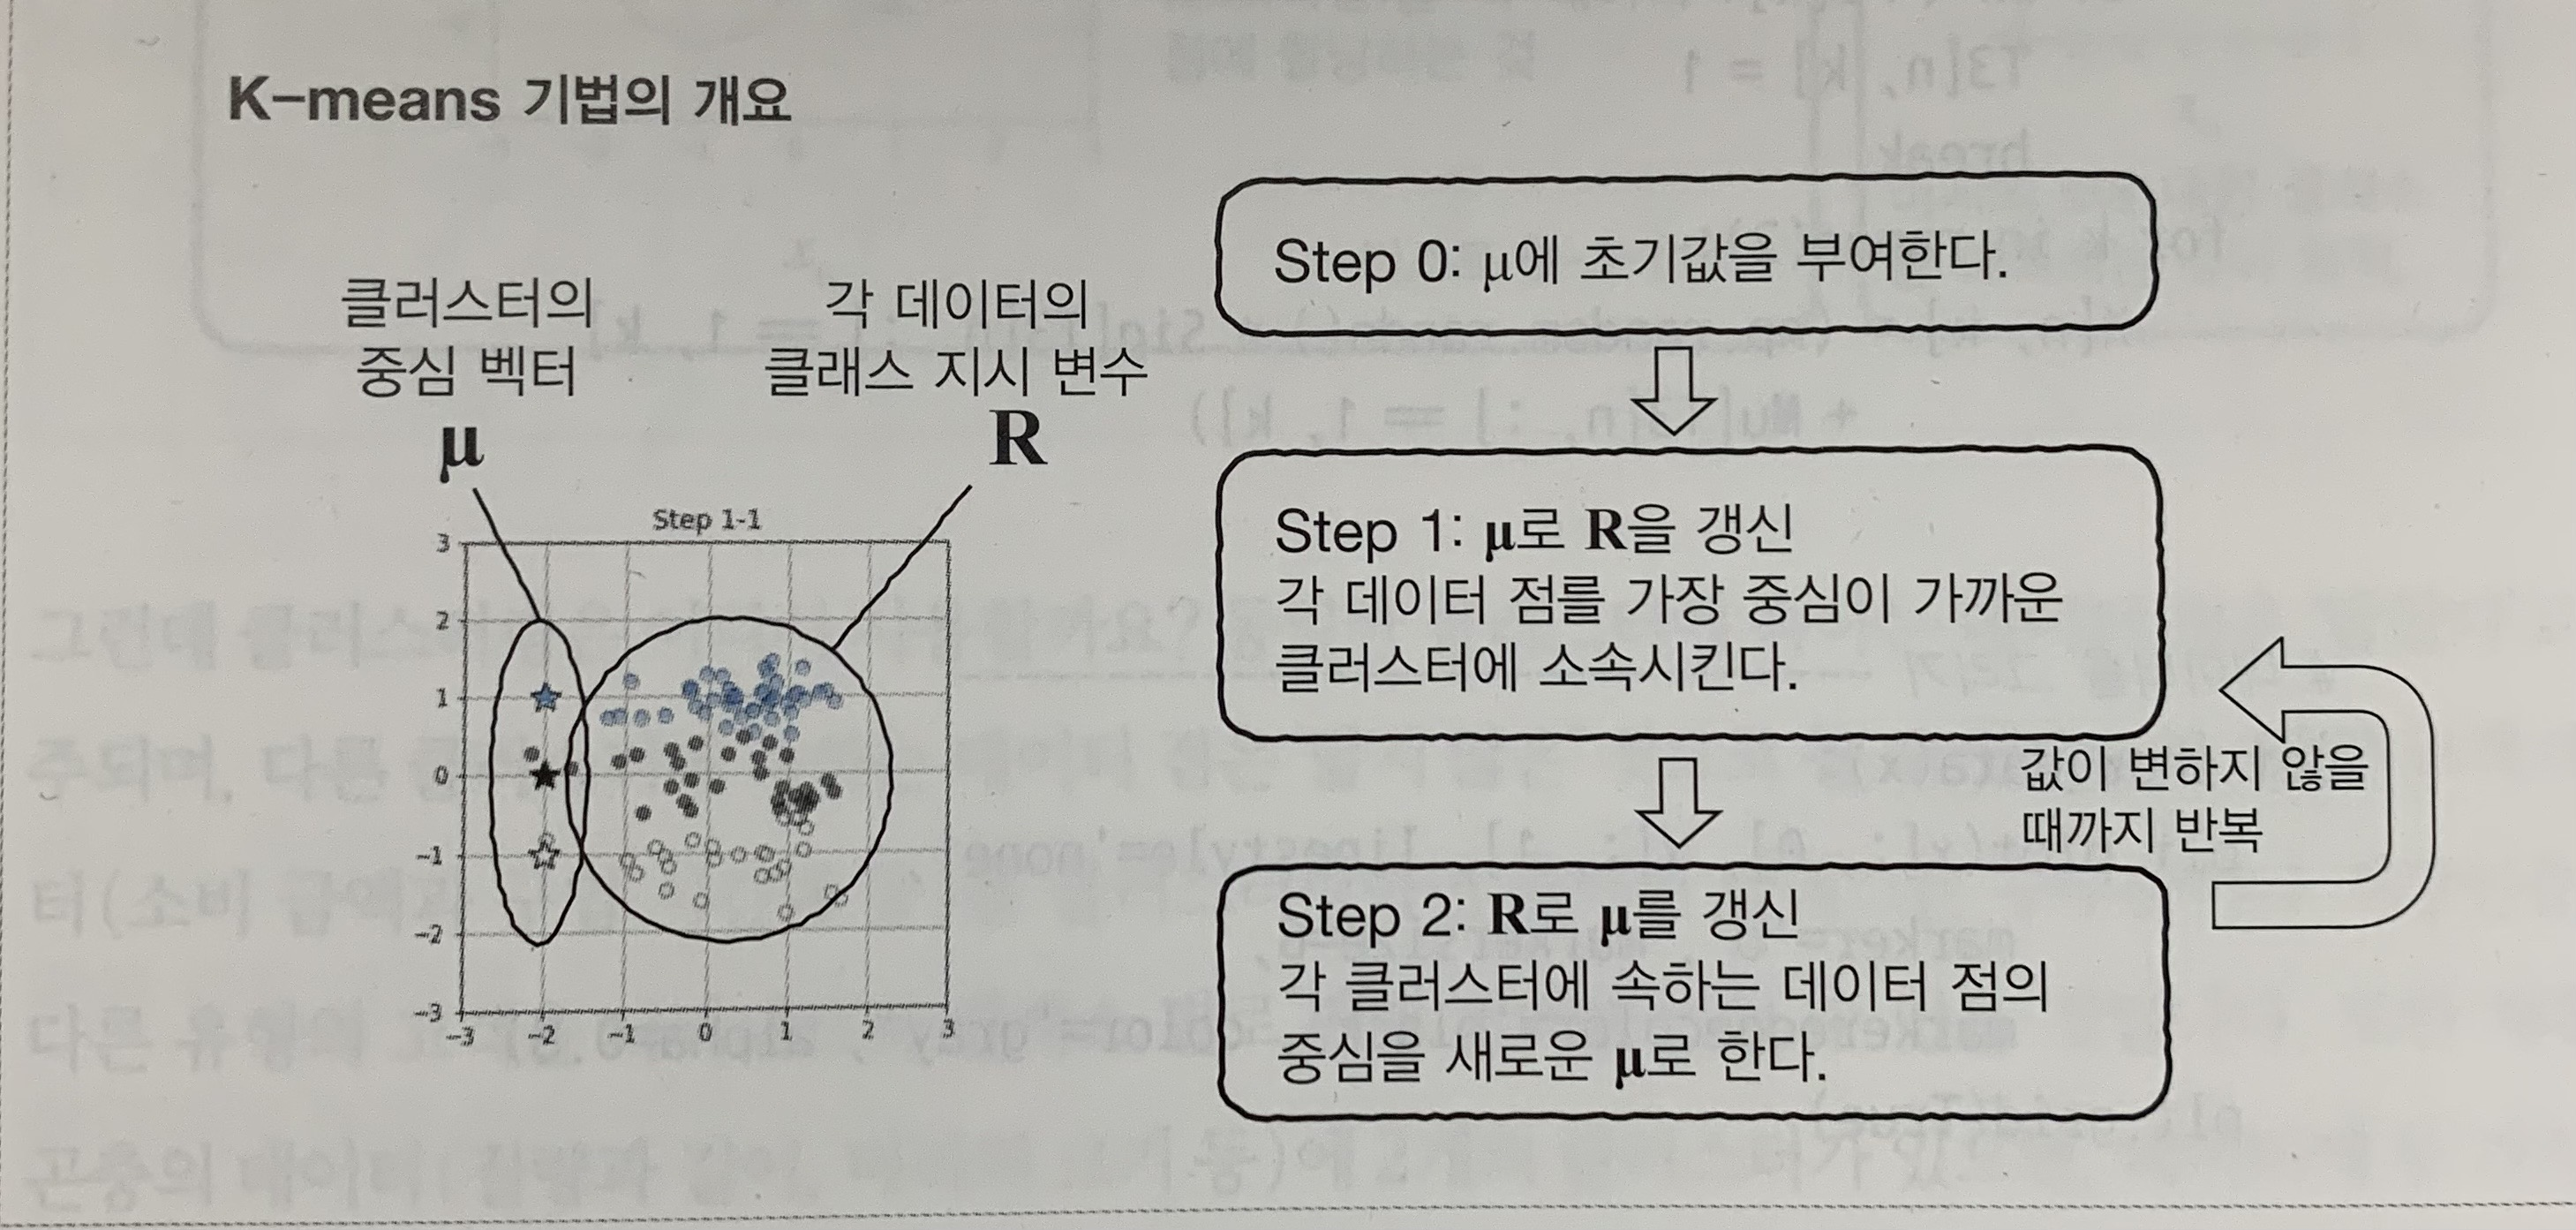


* K-means 기법과 가우시안 혼합 모델은 미리 분할할 클러스터의 수 K를 결정해야함

* K-means 기법에서는 두 변수를 사용. 하나는 클러스터의 중심 벡터 $\mu$로, 클러스터의 중심 위치를 나타냄. 다른 하나는 클래스 지시 변수 R이며, 각 데이터 점이 어떤 클러스터에 속하는지를 나타냄

* Step 0: 클러스터의 중심 벡터 $\mu$에 적절한 값을 제공(이것으로 클러스터의 중심이 잠정적으로 결정됨)

* Step 1: 현 시점에서 클러스터의 중심 벡터 $\mu$를 바탕으로, 클래스 지시 변수 R을 결정

* Step 2: 현 시점에서 클래스 지시 변수 R로 $\mu$를 갱신

###**9.2.2 Step 0:변수의 준비와 초기화**

* k 번째 클러스터의 중심 벡터는 $u_k = [u_{k0},u_{k1}]$으로 나타낸다.

* 입력 차원이 2차원이므로 클러스터 중심도 2차원 벡터가 된다.

* 클래스 지시 변수 R은 각 데이터가 어느 클래스에 속해 있는지를 1-of-K 부호화법으로 나타낸 행렬이다.

* 데이터 n이 k에 속하는 경우 $r_{nk} = 1$

* 데이터 n이 k에 속하지 않은 경우 $r_{nk} = 0$

* 데이터 n에 대한 클래스 지시 변수를 벡터로 나타내면, 클래스 0에 속하는 경우는 다음과 같다. $r_n = [r_{n0},r_{n1},r_{n2}] = [1,0,0]$



In [ ]:
# Mu 및 R 초기화 -----------------------------
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]]) # (A)
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)] # (B)

* 여기서 정의한 Mu는 3개의 $\mu_k$를 한 덩어리로 묶은 3 x 2 행렬이다

* 모든 데이터가 클래스 0에 속하도록 R을 초기화(R은 Mu로 결정되기 때문에 어떻게 초기화 하든 다음 알고리즘의 결과에 영향을 주지 않음)

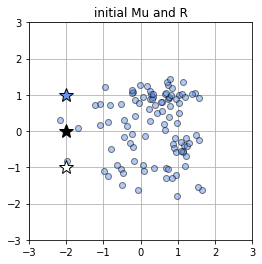

In [ ]:
# 데이터를 그리는 함수 ---------------------------
def show_prm(x, r, mu, col):
    for k in range(K):
        # 데이터 분포의 묘사
        plt.plot(x[r[:, k] == 1, 0], x[r[:, k] == 1, 1],
                 marker='o',
                 markerfacecolor=X_col[k], markeredgecolor='k',
                 markersize=6, alpha=0.5, linestyle='none')
        # 데이터의 평균을 "별표"로 묘사
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=X_col[k], markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
    plt.grid(True)


# ------------------------------
plt.figure(figsize=(4, 4))
R = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
show_prm(X, R, Mu, X_col)
plt.title('initial Mu and R')
plt.show()

###**9.2.3 Step 1:R의 갱신**

* R을 갱신하는 방법은 각 데이터 점을 가장 중심이 가까운 클러스터에 넣는것

* $|x_n - \mu_k|^2 = (x_{n0} - \mu_{k0})^2 + (x_{n1} - \mu_{k1})^2$ -> 데이터 점에서 클러스터 중심까지의 제곱 거리를 각 클러스터에 대해 구하는 식

* 거리 자체를 알고싶은 것이 아니라 데이터 점에서 가장 가까운 클러스터를 알고싶기 때문에, 제곱근의 계산을 생략한 제곱 거리 사용하여 비교


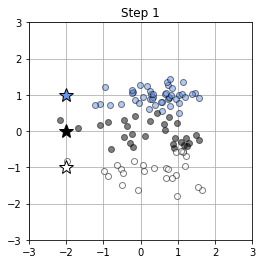

In [ ]:
# r을 결정한다 (Step 1) -----------
def step1_kmeans(x0, x1, mu):
    N = len(x0)
    r = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = (x0[n] - mu[k, 0])**2 + (x1[n] - mu[k, 1])**2
        r[n, np.argmin(wk)] = 1
    return r


# ------------------------------
plt.figure(figsize=(4, 4))
R = step1_kmeans(X[:, 0], X[:, 1], Mu)
show_prm(X, R, Mu, X_col)
plt.title('Step 1')
plt.show()

###**9.2.4 Step 2: $\mu$의 갱신**

* $\mu$를 갱신하는 방법은 각 클러스터에 속하는 데이터 점의 중심을 새로운 $\mu$로 하는 것이다.

* 이를 식으로 나타내면 다음과 같다 $$\mu_{k,0} = \frac{1}{N_k}\sum_{n in cluster k}x_{n0}, \mu_{k,1} = \frac{1}{N_k}\sum_{n in cluster k}x_{n1} (k = 0,1,2)$$ 



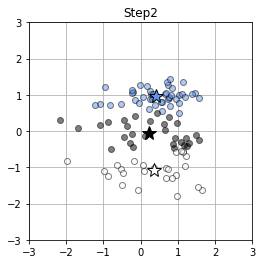

In [ ]:

# Mu 결정 (Step 2) ----------
def step2_kmeans(x0, x1, r):
    mu = np.zeros((K, 2))
    for k in range(K):
        mu[k, 0] = np.sum(r[:, k] * x0) / np.sum(r[:, k])
        mu[k, 1] = np.sum(r[:, k] * x1) / np.sum(r[:, k])
    return mu


# ------------------------------
plt.figure(figsize=(4, 4))
Mu = step2_kmeans(X[:, 0], X[:, 1], R)
show_prm(X, R, Mu, X_col)
plt.title('Step2')
plt.show()

* 이 후에는 Step 1과 Step 2의 절차를 반복하면 됨

* 변수의 값이 변화하지 않으면 프로그램 종료

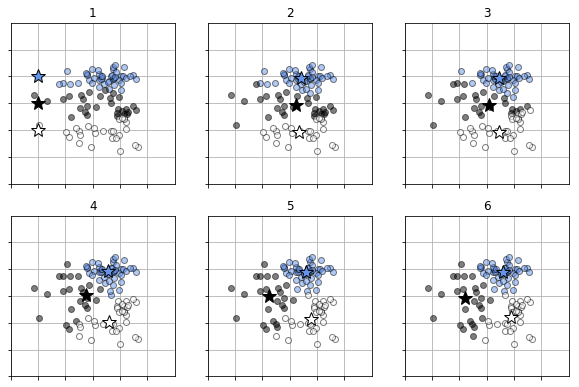

In [ ]:
# ----------------- 리스트 9-1-(6)
plt.figure(1, figsize=(10, 6.5))
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
max_it = 6 # 반복 횟수
for it in range(0, max_it):
    plt.subplot(2, 3, it + 1)
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    show_prm(X, R, Mu, X_col)
    plt.title("{0:d}".format(it + 1))
    plt.xticks(range(X_range0[0], X_range0[1]), "")
    plt.yticks(range(X_range1[0], X_range1[1]), "")
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
plt.show()

* 서서히 Mu가 3개의 클러스터의 중심으로 이동하고, 각 클러스터마다 다른 라벨이 할당된 것을 알 수 있다.

###**9.2.5 왜곡 척도**

* K-means 기법의 경우, 데이터 점이 속한 클러스터의 중심까지의 제곱 거리를 전체 데이터로 합한 것이 목적 함수에 대응하고 이를 왜곡 척도라고 한다.

$$J = \sum_{n in cluster 0} |x_n - \mu_0|^2 + \sum_{n in cluster 1} |x_n - \mu_1|^2 + \sum_{n in cluster 2} |x_n - \mu_2|^2$$

$$J = \sum_{n in cluster 0}^2 |x_n - \mu_k|^2$$

* 이 식에서 $r_{nk}$는 데이터 n이 속한 클러스터에서만 1, 속하지 않는 클러스터에서는 0이 되는 변수라는 사실을 이용해 식을 다음과 같이 변경할 수 있음

$$J = \sum_{n=0}^{N-1}\sum_{k=0}^{K-1} r_{nk}|x_n - \mu_k|^2$$



In [ ]:

# 목적 함수(왜곡척도) ----------------------------------
def distortion_measure(x0, x1, r, mu):
    # 입력은 2차원으로 제한하고 있다
    N = len(x0)
    J = 0
    for n in range(N):
        for k in range(K):
            J = J + r[n, k] * ((x0[n] - mu[k, 0])**2
                               + (x1[n] - mu[k, 1])**2)
    return J


# ---- test
# ---- Mu와 R의 초기화
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
distortion_measure(X[:, 0], X[:, 1], R, Mu)

771.7091170334878

[627.54  73.39  70.39  57.59  48.31  47.28  46.86  46.86  46.86  46.86]


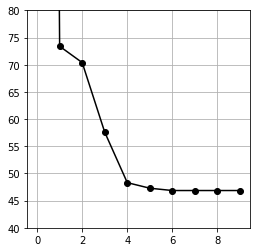

In [ ]:

# Mu와 R의 초기화
N=X.shape[0]
K=3
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
R = np.c_[np.ones((N, 1), dtype=int), np.zeros((N, 2), dtype=int)]
max_it = 10
it = 0
DM = np.zeros(max_it) # 왜곡 척도의 계산 결과를 넣는다
for it in range(0, max_it): # K-means 법
    R = step1_kmeans(X[:, 0], X[:, 1], Mu)
    DM[it] = distortion_measure(X[:, 0], X[:, 1], R, Mu) # 왜곡 척도
    Mu = step2_kmeans(X[:, 0], X[:, 1], R)
print(np.round(DM, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(DM, color='black', linestyle='-', marker='o')
plt.ylim(40, 80)
plt.grid(True)
plt.show()

* Step을 진행할수록 왜곡 척도는 점차 감소하고 Step 6에서 값이 멈춤

* 이는 $\mu$와 R값이 변화하지 않는 것을 의미한다.

* K-means 기법으로 얻을 수 있는 해는 초기값 의존성이 있다.
* 처음 $\mu$에 무엇을 할당하는지에 따라 결과가 달라질 수 있다.
* 실제는, 다양한 $\mu$에서 시작하여 얻은 결과 중에 가장 왜곡 척도가 작은 결과를 사용하는 방법이 사용된다.
* 예제에서는 $\mu$를 먼저 정했지만 R을 먼저 결정해도 괜찮다. 이 경우 R을 임의로 정해서 거기서 $\mu$를 찾아가는 절차가 된다.

##**9.3 가우시안 혼합 모델**

###**9.3.1 확률적 클러스터링**

* 데이터 점 B가 클러스터 0과 클러스터 1에 모두 속해 있다는 모호성을 포함해 수치화하기 위해서 확률적 개념을 도입한다.

* 예를 들어, 데이터 점 A가 클러스터 0에 속할 확률은 0.9, 1과 2에 속할 확률은 각각 0.1과0.0이라고 할 때 이것을 $\gamma_A$를 사용하여 다음과 같이 나타낸다.
$$\gamma_A = [\gamma_{A0},\gamma_{A1},\gamma_{A2}] = [0.9,0.1,0.1]$$

* 어떤 쪽의 클러스터에는 반드시 속하므로 3개의 확률을 더하면 1이 된다.

* 즉 $\gamma$ 값을 클러스터 k에 속할 확률이라고 간단하게 설명할 수 있다.

* 이를 자세히 살펴보면 우선 '같은 종류의 곤충'이라고 생각하고, 여러 마리를 채취하여 질량과 크기의 데이터를 기록하고 200마리를 모아 플롯한 결과. 3개의 클러스터가 있는 것으로 나타났다고 하면

* 이 경우 실은 '적어도 세 가지의 변종이 있었다.'고 해석할 수 있다.

* 모든 곤충은 어떤 쪽의 변종에 속해 있으며, 이에 따라 질량과 크기가 정해잔디고 생각할 수 있다.

* 3개의 클러스터의 뒤에 3개의 클래스의 존재가 암시된 것이다.

* 이렇게 관찰은 못했지만 데이터에 영향을 준 변수를 잠재 변수 또는 숨은 변수라고 한다.

* 이 잠재 변수를 3차원 벡터를 사용하여 1-of-K 부호화법으로 표현할 수 있다.
$$z_n = [z_{n0},z_{n1},z_{n2}]$$

* 데이터 n이 클래스에 k에 속한다면 $z_{nk}$만 1을 취하고, 다른 요소는 0으로 한다. 그리고 모든 데이터를 정리하여 행렬로 나타낼 때는 Z와 같이 대문자로 표시한다.(이는 K-means 기법의 R과 거의 같다.)

* 이 관점에서 데이터 n이 클러스터 k에 속할 확률 $\gamma_{nk}$란 데이터 xn인 곤충이 클래스 k의 변종일 확률을 의미한다.
$$\gamma_{nk} = P(z_{nk} = 1|X_n)$$

* 단적으로 말하면 관찰할 수 없는 Z의 추정치가 $\gamma$다. 또한 $\gamma$는 어떤 클러스터에 얼마나 기여하고 있는가라는 의미에서 부담률이라고 한다.

* 정리하면 확률적 클러스터링은 데이터의 배후에 숨어 있는 잠재 변수 Z를 확률적으로 $\gamma$로 추정하는 것이다.

###**9.3.2 가우시안 혼합 모델**

* 가우시안 혼합 모델은 2차원 가우스 함수 여러 개를 합친 것

$$ p(x) = \sum_{k=0}^{K-1}\pi_kN(x|\mu_k,\Sigma_k)$$

* $N(x|\mu_k,\Sigma_k)$는 평균 $\mu_k$ 공분산 행렬 $\Sigma_k$의 2차원 가우스 함수를 나타낸다.

* 위의 식은 서로 다른 평균과 공분산 행렬을 가진 2차원 가우스 함수가 K개 겹친 분포를 나타낸다.

* 모델의 매개 변수는 각 가우스 분포의 중심을 나타내는 중심 벡터 $\mu_k$, 분포의 퍼짐을 나타내는 공분산 행렬 $\Sigma_k$, 그리고 각 가우스 분포의 크기의 비율을 나타내는 혼합 계수 $\pi_k$다.

* 혼합 계수는 0과 1사이의 실수로, K로 합을 취해 1이 되어야 한다.






In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:

import numpy as np
wk = np.load('data_ch9.npz')
X = wk['X']
X_range0 = wk['X_range0']
X_range1 = wk['X_range1']

In [ ]:

# 가우스 함수 -----------------------------
def gauss(x, mu, sigma):
    N, D = x.shape
    c1 = 1 / (2 * np.pi)**(D / 2)
    c2 = 1 / (np.linalg.det(sigma)**(1 / 2))
    inv_sigma = np.linalg.inv(sigma)
    c3 = x - mu
    c4 = np.dot(c3, inv_sigma)
    c5 = np.zeros(N)
    for d in range(D):
        c5 = c5 + c4[:, d] * c3[:, d]
    p = c1 * c2 * np.exp(-c5 / 2)
    return p

* 가우스 함수의 인수는 x는 N x D의 데이터 행렬

*mu는 길이 D인 중심 벡터, sigma는 D x D의 공분산 행렬

In [ ]:

x = np.array([[1, 2], [2, 1], [3, 4]])
mu = np.array([1, 2])
sigma = np.array([[1, 0], [0, 1]])
print(gauss(x, mu, sigma))

[0.15915494 0.05854983 0.00291502]


In [ ]:

# 혼합 가우시안 모델 ----------------------
def mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    p = np.zeros(N)
    for k in range(K):
        p = p + pi[k] * gauss(x, mu[k, :], sigma[k, :, :])
    return p

In [ ]:

# test -------------------------------
x = np.array([[1, 2], [2, 2], [3, 4]])
pi = np.array([0.3, 0.7])
mu = np.array([[1, 1], [2, 2]])
sigma = np.array([[[1, 0], [0, 1]], [[2, 0], [0, 1]]])
print(mixgauss(x, pi, mu, sigma))

[0.09031182 0.09634263 0.00837489]


In [ ]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
# 혼합 가우스 등고선 표시 ----------------------
def show_contour_mixgauss(pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    plt.contour(x0, x1, f, 10, colors='gray')


# 혼합 가우스 3D 표시 ---------------------------
def show3d_mixgauss(ax, pi, mu, sigma):
    xn = 40 # 등고선 표시 해상도
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    f = mixgauss(x, pi, mu, sigma)
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, rstride=2, cstride=2, alpha=0.3,
                    color='blue', edgecolor='black')

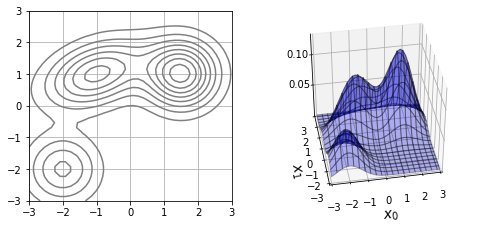

In [ ]:

# test -----------------------------------
pi = np.array([0.2, 0.4, 0.4])
mu = np.array([[-2, -2], [-1, 1], [1.5, 1]])
sigma = np.array(
    [[[.5, 0], [0, .5]], [[1, 0.25], [0.25, .5]], [[.5, 0], [0, .5]]])


Fig = plt.figure(1, figsize=(8, 3.5))
Fig.add_subplot(1, 2, 1)
show_contour_mixgauss(pi, mu, sigma)
plt.grid(True)


Ax = Fig.add_subplot(1, 2, 2, projection='3d')
show3d_mixgauss(Ax, pi, mu, sigma)
Ax.set_zticks([0.05, 0.10])
Ax.set_xlabel('$x_0$', fontsize=14)
Ax.set_ylabel('$x_1$', fontsize=14)
Ax.view_init(40, -100)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

* K = 3일 때의 가우시안 혼합 모델의 예를 나타낸다.

* 중심과 분포의 퍼짐이 다른 가우스 분포 3개가 겹치는 형태임을 알 수 있다.

###**9.3.3 EM 알고리즘의 개요**

* 가우시안 혼합 모델을 사용하여 데이터의 클러스터링을 수행한다.

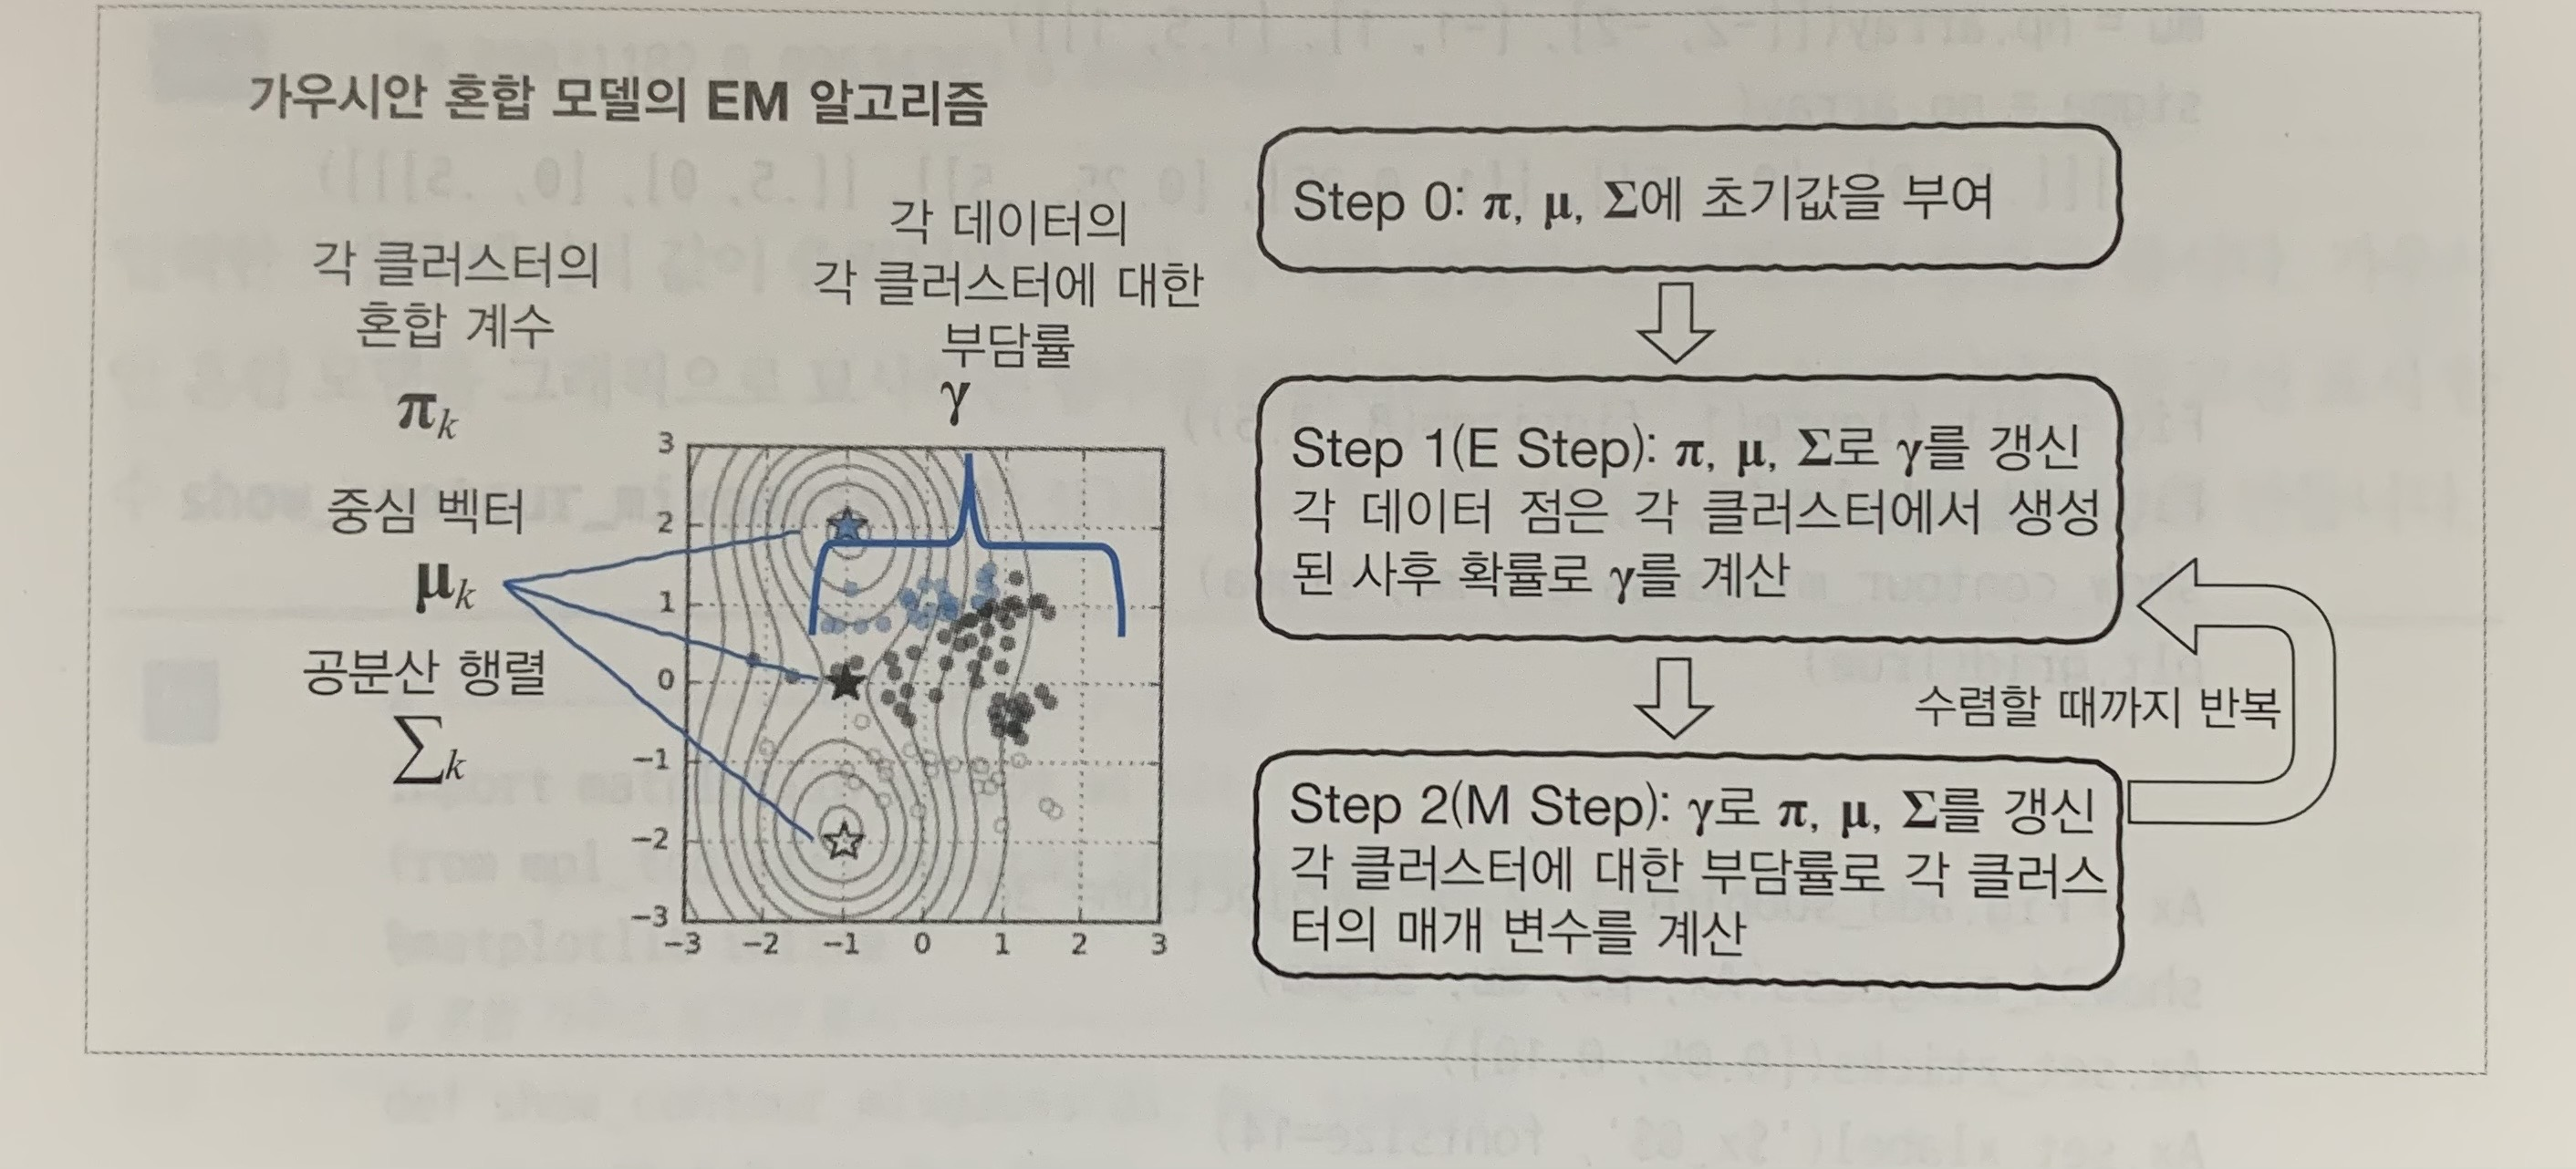

* 가우시안 혼합 모델은 중심 벡터 $\mu$ 뿐만 아니라 공분산 행렬 $\Sigma$에 의해 각 클러스터의 확산 정도를 기술한다. 또한 혼합 계수 $\pi$에 의해 각 클러스터의 크기의 차이를 설명한다.

* 가우시안 혼합 모델은 각 클래스에 속할 확률에 대응하는 부담률 $\gamma$를 출력한다.

* Step 0: $\pi,\mu,\Sigma$초기화

* Step 1: 현시점의 $\pi,\mu,\Sigma$를 사용하여 $\gamma$를 구한다.(E Step)

* Step 2: 현시점의 $\gamma$를 사용하여 $\pi,\mu,\Sigma$를 구한다.(M Step)

* E Step과 M Step을 매개 변수가 수렴할 때까지 반복한다.

###**9.3.4 Step 0:변수의 준비 및 초기화**



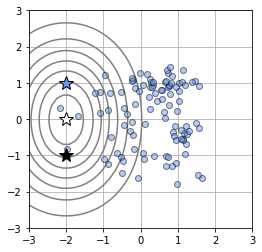

In [ ]:

# 초기 설정 ------------------------------------
N = X.shape[0]
K = 3
Pi = np.array([0.33, 0.33, 0.34])
Mu = np.array([[-2, 1], [-2, 0], [-2, -1]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


X_col=np.array([[0.4, 0.6, 0.95], [1, 1, 1], [0, 0, 0]])


# 데이터를 그리기 ------------------------------
def show_mixgauss_prm(x, gamma, pi, mu, sigma):
    N, D = x.shape
    show_contour_mixgauss(pi, mu, sigma)
    for n in range(N):
        col=gamma[n,0]*X_col[0]+gamma[n,1]*X_col[1]+gamma[n,2]*X_col[2]
        plt.plot(x[n, 0], x[n, 1], 'o',
                 color=tuple(col), markeredgecolor='black',
                 markersize=6, alpha=0.5)
    for k in range(K):
        plt.plot(mu[k, 0], mu[k, 1], marker='*',
                 markerfacecolor=tuple(X_col[k]), markersize=15,
                 markeredgecolor='k', markeredgewidth=1)
        
        
    plt.grid(True)


plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

* 초기값으로 할당한 중심 벡터가 인정해 있기 떄문에 3개의 가우스 함수가 겹쳐 세로로 긴 산과 같은 분포가 표현되어 있다.

###**9.3.5 Step 1(E Step): $\gamma$ 갱신**

* 부담률 $\gamma$를 모든 n과 k에 대해 갱신한다.

$$\gamma_{nk} = \frac{\pi_kN}{\sum_{k`}^kN}  \gamma_{nk} = \frac{\pi_kN(x_n|\mu_k,\Sigma_k)}{\sum_{k`}^kN(x_n|\mu_{k`},\Sigma_{k`})}$$

* 어떤 데이터 점 n에 착안했을 때, 그 데이터 점에서의 각 가우스 함수의 높이 $ a _k = \pi_kN(x_n|\mu_k,\Sigma_k)$를 구한다.

* 그리고 k에서 합을 취해 1이 되도록 $a_k$의 총합 $\sum_{k`}^k,a_{k`}$로 나누어 규격화한 것을 $gamma_{nk}$로 한다.

* 즉 가우스 함수의 값이 높을수록 부담률도 높아진다는 직관적인 갱신 방법이라고 할 수 있다.

In [ ]:

# gamma 갱신 (E Step) -------------------
def e_step_mixgauss(x, pi, mu, sigma):
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    gamma = np.zeros((N, K))
    for n in range(N):
        wk = np.zeros(K)
        for k in range(K):
            wk[k] = pi[k] * y[n, k]
        gamma[n, :] = wk / np.sum(wk)
    return gamma


# 메인 ----------------------------------
Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)

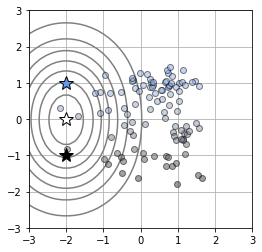

In [ ]:

# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

###**9.3.6 Step 2(M Step): $\pi,\mu,\Sigma$의 갱신**

* 우선 각 클러스터에 대한 부담률의 합 $N_k$를 구한다.

$$ N_k = \sum_{n=0}^{N-1}\gamma_{nk}$$

* 위의 식을 바탕으로 혼합률 $\pi_k$를 갱신한다.

$$\pi_k^{new} = \frac{N_k}{N}$$

* N은 전체 데이터 수이므로 혼합률은 전체에 대한 클러스터 내 수의 비율이 되는, 적합한 갱신식이다.

* 다음으로 중심벡터 $\mu_k$를 갱신한다.

$$ \mu_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}\gamma_{nk}x_n$$

* 위의 식은 클러스터에 부담률의 가중치를 더한 데이터의 평균이 되고 있다. 이것은 K-means 기법에서 말하는 '클러스터 데이터의 평균을 구한다'는 Step 2에 해당한다.

* 마지막으로, 가우스의 공분산 행렬을 갱신한다. 갱신식에는 앞에서 구한 $\mu_k^{new}$가 사용된다.

$$\Sigma_k^{new} = \frac{1}{N_k}\sum_{n=0}^{N-1}\gamma_{nk}(x_n-\mu_k^{new})^T(x_n-\mu_k^{new})$$

*위 식은 클러스터에 부담률의 가중치를 더한 데이터의 공분산 행렬을 구하는 것이며, 가우스 함수를 데이터에 피팅할 때의 공분산 행렬을 구하는 방법과 유사하다.


In [ ]:

# Pi, Mu, Sigma 갱신 (M step) ------------
def m_step_mixgauss(x, gamma):
    N, D = x.shape
    N, K = gamma.shape
    # pi를 계산
    pi = np.sum(gamma, axis=0) / N
    # mu을 계산
    mu = np.zeros((K, D))
    for k in range(K):
        for d in range(D):
            mu[k, d] = np.dot(gamma[:, k], x[:, d]) / np.sum(gamma[:, k])
    # sigma를 계산
    sigma = np.zeros((K, D, D))
    for k in range(K):
        for n in range(N):
            wk = x - mu[k, :]
            wk = wk[n, :, np.newaxis]
            sigma[k, :, :] = sigma[k, :, :] + gamma[n, k] * np.dot(wk, wk.T)
        sigma[k, :, :] = sigma[k, :, :] / np.sum(gamma[:, k])
    return pi, mu, sigma


# 메인 ----------------------------------
Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)

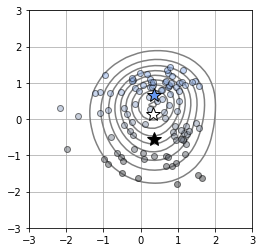

In [ ]:

# 표시 ----------------------------------
plt.figure(1, figsize=(4, 4))
show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
plt.show()

* 중심 벡터를 나타내는 별표가 훨씬 더 클러스터의 중심으로 이동한 것을 확인할 수 있다.

* 다음은 E Step과 M Step을 반복할 뿐이다.

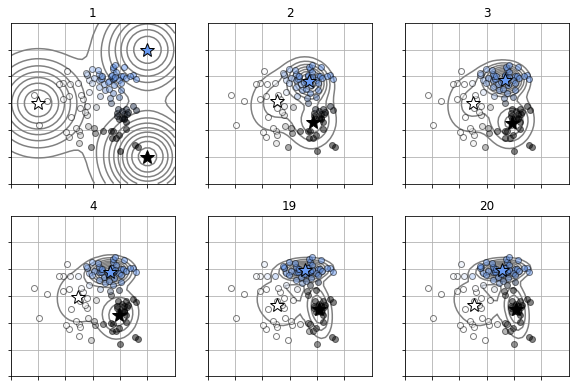

In [ ]:

Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]
plt.figure(1, figsize=(10, 6.5))
max_it = 20 # 반복 횟수


i_subplot=1;
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    if it<4 or it>17:
        plt.subplot(2, 3, i_subplot)
        show_mixgauss_prm(X, Gamma, Pi, Mu, Sigma)
        plt.title("{0:d}".format(it + 1))
        plt.xticks(range(X_range0[0], X_range0[1]), "")
        plt.yticks(range(X_range1[0], X_range1[1]), "")
        i_subplot=i_subplot+1
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)
plt.show()

* 최종적으로 3개의 별에 나타난 중심 벡터는 각 클러스터의 중심 부근에 정착했다.

* 각 데이터의 클러스터에 소속이 부담률이라는 확률로 표현되었다.(색깔로 표현)

* 클러스터링 결과는 K-means 방법과 마찬가지로 매개 변수의 초기값에 따라 달라진다. 따라서 실질적으로는 다양한 초기값을 사용해 가장 좋은 결과를 선택하게 된다.

* 클러스터링의 장점을 평가하기 위해 가우스 혼합 모델의 경우는 가능도를 사용한다.

###**9.3.7 가능도**

* 가우시안 혼합 모델은 데이터의 분포 p(x)를 나타내는 모델이다.

* EM알고리즘은 가우시한 혼합 모델이 입력 데이터 X의 분포에 맞게 매개 변수를 갱신하는 알고리즘이다.

* 입력 데이터가 조밀한 부분에 가우스 함수가 배치되어, 입력 데이터가 띄엄띄엄한 부분은 분포값이 낮도록 매개 변수가 조정되었다. 그 결과 각 가우스 분포가 다른 클러스터를 나타낸 것이다.

* EM 알고리즘의 목적함수는 가능도다. 즉 입력 X는 가우시안 혼합 모델에서 생성된 것으로 생각하여, X가 생성된 확률(가능도)이 가장 높도록 매개 변수가 갱신되고 있다.

* 가능도는 모든 데이터 점 X가 모델에서 생성된 확률이므로 다음 식과 같이 표현할 수 있다.

$$p(X|\pi,\mu,\Sigma) = \prod_{n=0}^{N-1}\sum_{k=0}^{K-1}\pi_kN(x_n|\mu_k,\Sigma_k)$$\\

*여기에 로그를 취한 로그 가능도는 다음과 같다.

$$logp(X|\pi,\mu,\Sigma) = \sum_{n=0}^{N-1}\{log\sum_{k=0}^{K-1}\pi_kN(x_n|\mu_k,\Sigma_k)\}$$

* 가능도나 로그 가능도를 최적화 시킬때는 극대화 하기 때문에 -1을 곱한 음의 로그 가능도를 오차 함수로 정의한다.

$$E(\pi,\mu,\Sigma)=-logp(X|\pi,\mu,\Sigma) = -\sum_{n=0}^{N-1}\{log\sum_{k=0}^{K-1}\pi_kN(x_n|\mu_k,\Sigma_k)\}$$

* 매개 변수를 다시 기본값으로 초기화하여 오차 함수가 알고리즘의 갱신 단계에서 단조롭게 감소했는지를 살펴본다.

In [ ]:

# 혼합 가우스의 목적 함수 ----------------------
def nlh_mixgauss(x, pi, mu, sigma):
    # x: NxD
    # pi: Kx1
    # mu: KxD
    # sigma: KxDxD
    # output lh: NxK
    N, D = x.shape
    K = len(pi)
    y = np.zeros((N, K))
    for k in range(K):
        y[:, k] = gauss(x, mu[k, :], sigma[k, :, :]) # KxN
    lh = 0
    for n in range(N):
        wk = 0
        for k in range(K):
            wk = wk + pi[k] * y[n, k]
        lh = lh + np.log(wk)
    return -lh

[426.22 229.86 224.32 220.8  218.63 216.93 215.93 215.51 215.33 215.24
 215.18 215.15 215.13 215.11 215.1  215.1  215.09 215.09 215.08 215.08]


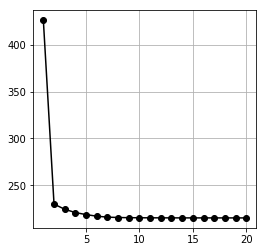

In [ ]:

Pi = np.array([0.3, 0.3, 0.4])
Mu = np.array([[2, 2], [-2, 0], [2, -2]])
Sigma = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
Gamma = np.c_[np.ones((N, 1)), np.zeros((N, 2))]


max_it = 20
it = 0
Err = np.zeros(max_it) # distortion measure
for it in range(0, max_it):
    Gamma = e_step_mixgauss(X, Pi, Mu, Sigma)
    Err[it] = nlh_mixgauss(X,Pi,Mu,Sigma)
    Pi, Mu, Sigma = m_step_mixgauss(X, Gamma)


print(np.round(Err, 2))
plt.figure(2, figsize=(4, 4))
plt.plot(np.arange(max_it) + 1,
Err, color='k', linestyle='-', marker='o')
#plt.ylim([40, 80])
plt.grid(True)
plt.show()

* 음의 로그 가능도는 점차 감소해 Step 10 정도에서 대부분 수렴하는 것을 알 수 있다.

* 음의 로그 가능도를 계산하는 알고리즘이 제대로 작동하고 있는지를 체크할 수 있으며, 반복 계산의 종료 조건에도 사용할 수 있다.

----------------------------
#AFTER

* K-means 알고리즘의 장점
1. 데이터의 내부구조에 대한 사전적인 정보 없이 의미 있는 자료구조를 찾아낼 수 있다.
2. 간단한 알고리즘이며, 대규모 적용이 가능하다
3. 분석을 위해서 기본적으로 관찰치 간의 거리를 데이터 형태에 맞게만 정리하면, 거의 모든 형태의 데이터에 대하여 적용이 가능한 방법

* K-means 알고리즘의 단점
1. 데이터의 개수가 많을 경우 군집화의 정확도가 떨어진다.
2. 반복 횟수가 많아질수록 수행시간이 오래 걸린다.
3. 군집을 몇개로 할지 정하기 어렵다.
4. 군집을 잘 정해주지 않으면 좋은 결과를 얻을 수 없다.
5. 데이터의 구조가 구형이 아닌 복잡한 형태일수록 정확도가 떨어진다.
6. 멀리 떨어진 데이터에 민감하다.

* 적절한 K를 정하는 방법
1. 엘보우 기법
>* K 값을 1부터 특정 값까지 증가시키면서 군집화를 실행하여 실행하는 동안 클러스터내의 오차제곱합이 최소가 되도록 하는 방법. 즉 오차제곱합이 최소가 되는 클러스터 갯수를 최적의 클러스터 갯수로 가정한다.
>* 눈으로 직접확인해야 한다는 단점이 있음. 자동화하려면 미분을 하는 방법이 있지만 경우에 따라 정확하지 않을 수 있다.
![엘보우](https://mblogthumb-phinf.pstatic.net/MjAxOTA2MjRfMjY1/MDAxNTYxMzEwMjA5ODA0.MfLRKFhsQ5dy1oyIrFpU0W0JvcVT4RQ9PEji1BqKxH0g.LMz6oV1CE2tSNf2j2tJcRKeXPhTCo8fguiSImgJeoYgg.PNG.2feelus/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7_2019-06-24_%EC%98%A4%EC%A0%84_2.15.44.png?type=w2)

2. 실루엣 기법
> * 실루엣 분석은 각 군집간의 거리가 얼마나 효율적으로 분리 되어있는지를 나타낸다.
> *  여기서 효율적으로 잘 분리 됐다는 것은 다름 군집과의 거리는 떨어져 있고 동일한 군집끼리의 데이터는 서로 가깝게 잘 뭉쳐 있다는 의미다.
> * $ s^i =\frac{ b^{(i)}-a^{(i)}}{max(a^{(i)},b^{(i)})}$
> * a(i) = 데이터 응집도를 나타내는 값 , b(i) = 클러스터 간의 분리도
>* 실루엣 계수 값은 0~1의 값을 가진다. 1에 가까울 수록 클러스터의 갯수에 따른 데이터는 군집과 멀리 떨어져 있다는 뜻이고, 0에 가까울수록 근처의 군집과 가깝다는 뜻이다.
>* 실루엣 계수는 1에 가까울수록 최적화가 잘 되었다고 할 수 있다.


----------------------
##참고자료

* 엘보우 기법 : https://m.blog.naver.com/2feelus/221569121909
* 실루엣 기법 : https://velog.io/@rsj9987/TIL-21.05.27-K-means-cluster%EC%9D%98-K%EA%B0%92-%EA%B5%AC%ED%95%98%EA%B8%B0